In [ ]:
pip install bertopic

# Data prep

In [ ]:
import pandas as pd
from google.colab import drive

# Import BERT-ready data from Gdrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
BERT_df = pd.read_csv("/content/gdrive/MyDrive/Ironhack/Final_project/BERT_df.csv")

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Ironhack/Final_project/df_with_model_input_no_NaNs.csv")

In [ ]:
# Don't execute if no changes are made to the df
df.dropna(subset = ["model_input"], inplace=True)

In [ ]:
# Don't execute if no changes are made to the df
df.to_csv("/content/gdrive/MyDrive/Ironhack/Final_project/df_with_model_input_no_NaNs.csv")

In [ ]:
  # snippet to reduce number of words per BERT

In [ ]:
def preprocess_input(string, lst_to_remove):
  for item in lst_to_remove:
    string = string.replace(item, "")
  if len(string.split()) > 375:
    lst = string.split()[0:400]
    string = " ".join(map(str, lst))
  else:
    pass
  return str(string)

In [ ]:
import numpy as np

remove_lst = ["'review0': ","'review1': ","'review2': ","'review3': ","'review4': "]

# convert everything into str, add "" for all NaNs and then create a list for BERTopic to process
BERTs = df["model_input"].apply(lambda x: preprocess_input(str(x), remove_lst) if str(x) != "" else df["name"]).tolist()

# Create BERTopic model with custom model modules for embedding etc.

In [ ]:
#topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2")

In [ ]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sklearn.cluster import KMeans

# define stop words
lst = "i, me, my, myself, we, us, our, ours, ourselves, you, you're, you've, you'll, \
you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, \
herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, \
whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, \
has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, \
while, of, at, by, for, with, about, against, between, into, through, during, before, after, \
above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, \
there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, \
only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, \
d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, \
hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, needn, \
needn't, shan, shan't, shouldn, shouldn't, was, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't,\
good, nice, food, restaurant, nice, good, place, really, also, the, and, to, was"

stop_words_lst = lst.replace(" ","").split(",")

#0 define diversity of topic clusters
representation_model = MaximalMarginalRelevance(diversity=0.6)

#1 embedding model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(BERTs, show_progress_bar=True)
#2 dimensionality reduction model
# n_components represents the level of dimensionality after reduction of dimensions with UMAP
# -> the higher this number, the more dimensions. Very high dimensionality will mess with hdbscan later
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False)
#3 clustering model
#hdbscan_model = KMeans(n_clusters=35)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

#4 vectorizer model - transforming clusters into vector space
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words_lst)
#5 c-TF-IDF creating the topics from the vectorized clusters
ctfidf_model = ClassTfidfTransformer()#bm25_weighting=True, reduce_frequent_words=True)

# We reduce our embeddings to 2D as it will allows us to quickly iterate later on
#reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# assemble whole model
topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model,
                       hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       min_topic_size=10,
                       verbose=True, calculate_probabilities=True)

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

In [ ]:
from joblib import dump, load

# fit & transform the whole model
topics, probs = topic_model.fit_transform(BERTs)

# reduce no of topics
#topic_model.reduce_topics(BERTs, nr_topics=50)
#new_topics = topic_model.topics_

# Use the "c-TF-IDF" strategy with a threshold
new_topics = topic_model.reduce_outliers(BERTs, topics, strategy="c-tf-idf", threshold=0.1)

# Reduce all outliers that are left with the "embeddings" strategy
new_topics = topic_model.reduce_outliers(BERTs, new_topics, strategy="embeddings")

# Reduce all outliers that are left with the "distributions" strategy
#new_topics = topic_model.reduce_outliers(BERTs, new_topics, probabilities=probs, threshold=0.05, strategy="probabilities")

# update model, using the previously defined vectorizer_model
topic_model.update_topics(BERTs, topics=new_topics, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model)

# save model in a joblib file (safer than pickle)
dump(topic_model, '/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_MiniLM_eom_test_GPU.joblib')

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

2023-08-31 08:43:33,760 - BERTopic - Transformed documents to Embeddings
2023-08-31 08:44:10,586 - BERTopic - Reduced dimensionality
2023-08-31 08:44:11,545 - BERTopic - Clustered reduced embeddings


['/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_MiniLM_eom_test_GPU.joblib']

In [ ]:
topics, probs = topic_model.fit_transform(BERTs)

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

2023-08-31 09:00:58,522 - BERTopic - Transformed documents to Embeddings
2023-08-31 09:01:09,861 - BERTopic - Reduced dimensionality
2023-08-31 09:01:10,526 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,668,-1_great_service_delicious_friendly,"[great, service, delicious, friendly, staff, t...","[""incredible! such a beautiful restaurant with..."
1,0,757,0_pizza_italian_pasta_service,"[pizza, italian, pasta, service, great, friend...","[""first visit after covid times. sadly it was ..."
2,1,707,1_german_great_service_berlin,"[german, great, service, berlin, friendly, sch...",['great german restaurant we had lunch on a su...
3,2,426,2_service_great_friendly_staff,"[service, great, friendly, staff, delicious, b...",['nice menus every day with a very reasonable ...
4,3,280,3_kebab_doner_doner kebab_meat,"[kebab, doner, doner kebab, meat, best, always...","['guys, your doner kebab is really delicious. ..."
5,4,188,4_indian_chicken_paneer_curry,"[indian, chicken, paneer, curry, naan, ordered...","[""after a long day of traveling we stopped in ..."
6,5,152,5_sushi_order_fresh_delivery,"[sushi, order, fresh, delivery, ordered, great...",['we have been ordering from ryorii sushi for ...
7,6,100,6_vietnamese_pho_delicious_service,"[vietnamese, pho, delicious, service, friendly...","[""the second time having lunch in umami. love ..."
8,7,78,7_turkish_service_staff_friendly,"[turkish, service, staff, friendly, delicious,...",['very authentic turkish breakfast. the qualit...
9,8,77,8_falafel_shawarma_best_sandwich,"[falafel, shawarma, best, sandwich, halloumi, ...","['shawarma , falafel teller and shawarma telle..."


In [ ]:
topic_model.get_representations()

AttributeError: ignored

In [ ]:
topic, probs = topic_model.transform("tasty, good price, doner, doner kebap")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-09 16:53:24,172 - BERTopic - Reduced dimensionality
2023-03-09 16:53:24,188 - BERTopic - Calculated probabilities with HDBSCAN
2023-03-09 16:53:24,189 - BERTopic - Predicted clusters


In [ ]:
topic

[-1]

In [ ]:
topic_model.get_document_info(BERTs)

,Document,Topic,Name,Top_n_words,Representative_document
0,"'authentic german cuisine, friendly & fast ser...",1,1_german_schnitzel_beer_german cuisine,german - schnitzel - beer - german cuisine - t...,False
1,'this must be one of the best kept culinary se...,30,30_steak_fish_steaks_fish chips,steak - fish - steaks - fish chips - fresh fis...,False
2,'lovely authentic germany restaurant in a beau...,1,1_german_schnitzel_beer_german cuisine,german - schnitzel - beer - german cuisine - t...,False
3,"""my german friend took me here for an early ch...",1,1_german_schnitzel_beer_german cuisine,german - schnitzel - beer - german cuisine - t...,False
4,"""have a taste of germany in berlin. german bee...",1,1_german_schnitzel_beer_german cuisine,german - schnitzel - beer - german cuisine - t...,False
...,...,...,...,...,...
4297,'its a must go restaurant. in case you in mood...,20,20_greek_gyros_ouzo_greece,greek - gyros - ouzo - greece - tzatziki - bes...,False
4298,"'very authentic chinese restaurant, friendly s...",25,25_korean_chinese_dumplings_kimchi,korean - chinese - dumplings - kimchi - duck -...,False
4299,"'food taste is good for indian visitor', 'good...",16,16_indian_paneer_chicken_naan,indian - paneer - chicken - naan - tikka - mas...,False
4300,"""delicious food, kind service, a must stop for...",0,0_italian_pasta_pizza_wine,italian - pasta - pizza - wine - pizzas - pizz...,False


In [ ]:
topic_model.get_topic(6)

[('sushi', 0.44861432498281906),
 ('japanese', 0.2146500321573663),
 ('best sushi', 0.2114446809415596),
 ('rolls', 0.20329981003306027),
 ('delivery', 0.19591929156510005),
 ('maki', 0.18728374403035028),
 ('salmon', 0.1872510351952988),
 ('order', 0.185217714775521),
 ('rice', 0.18022566729672004),
 ('fresh', 0.17823915479073738)]

In [ ]:
topics_to_merge = [[6, 7],
                   [8, 9],
                   [12, 13],
                   [17, 27, 26],
                   [18, 19],
                   [22, 23],
                   [35, 36]]

topic_model.merge_topics(BERTs, topics_to_merge)

In [ ]:
topic_model.get_topic_info()

In [ ]:
dump(topic_model, '/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_MiniLM_eom_no_outliers_final_GPU.joblib')

['/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_MiniLM_eom_no_outliers_final_GPU.joblib']

In [ ]:
topic_model.visualize_documents(BERTs, reduced_embeddings=reduced_embeddings,
                                hide_document_hover=True, hide_annotations=True)

In [ ]:
new_topics = topic_model.reduce_outliers(BERTs, topics, probabilities=probs, threshold=0.05, strategy="probabilities")
topic_model.update_topics(BERTs, topics=new_topics)

In [ ]:
topic_model.visualize_documents(BERTs, reduced_embeddings=reduced_embeddings,
                                hide_document_hover=True, hide_annotations=True)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,793,0_german_schnitzel_beer_berlin
1,1,755,1_pizza_italian_pasta_pizzas
2,2,312,2_view_staff_room_location
3,3,295,3_kebab_doner_doner kebab_best doner
4,4,276,4_sushi_fish_asian_salmon
5,5,223,5_burger_burgers_fries_burgers fries
6,6,191,6_indian_paneer_naan_chicken
7,7,179,7_vietnamese_pho_rolls_spring
8,8,145,8_coffee_breakfast_cafe_cake
9,9,127,9_falafel_shawarma_hummus_lebanese


In [ ]:
topic_model.get_topic(62)

In [ ]:
from joblib import dump, load
topic_model = BERTopic.load('/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_custom_embeddings_mpnet_v1.joblib')

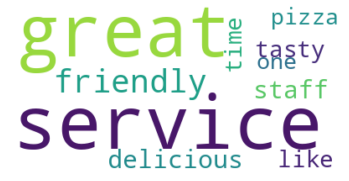

In [ ]:
create_wordcloud(topic_model, topic=-1)

In [ ]:
recluster = BERT_df.loc[topic_model.get_document_info(BERTs)["Topic"] == -1]["model_input"].apply(lambda x: str(x) if x != np.nan else "").tolist()

In [ ]:
topics_re, probs_re = topic_model.transform(recluster)

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

2023-03-07 14:28:54,117 - BERTopic - Reduced dimensionality
2023-03-07 14:28:54,901 - BERTopic - Calculated probabilities with HDBSCAN
2023-03-07 14:28:54,903 - BERTopic - Predicted clusters


In [ ]:
topics_re.count(-1)

2089

In [ ]:
topic_model.get_topic_info()

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from bertopic import BERTopic
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(topic_model, topic):
  text = {word: value for word, value in topic_model.get_topic(topic)}
  wc = WordCloud(background_color="white", max_words=1000)
  wc.generate_from_frequencies(text)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()

for i in range(len(topic_model.get_topic_info())-1):
  create_wordcloud(topic_model, topic=i)

# Creating custom embeddings for more precise clusters

In [ ]:
from joblib import dump, load

dump(custom_embeddings_model, '/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_custom_embeddings_v1.joblib')

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


['/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_custom_embeddings_v1.joblib']

In [ ]:
lst = "i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't, good, food, restaurant, also"
stop_words_lst = lst.replace(" ","").split(",")

In [ ]:
# !!!FOR TESTING!!!
# create custom embeddings for the text at hand for a more specific topic modelling with BERTopic:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic

from bertopic.representation import MaximalMarginalRelevance

#0 define diversity of topic clusters
representation_model = MaximalMarginalRelevance(diversity=0.8)

#1 custom embedding model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")#"all-mpnet-base-v2")
embeddings = sentence_model.encode(BERTs, show_progress_bar=False)
#2 dimensionality reduction model
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)
#3 clustering model
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)
#4 vectorizer model
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words=stop_words_lst)
#5 c-TF-IDF
ctfidf_model = ClassTfidfTransformer()

# Train our topic model using our pre-trained sentence-transformers embeddings
custom_embeddings_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model,
                       hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model, representation_model=representation_model,
                       min_topic_size=10, verbose=True)

In [ ]:
custom_topics, custom_probs = custom_embeddings_model.fit_transform(BERTs, embeddings)

2023-03-06 14:19:32,112 - BERTopic - Reduced dimensionality
2023-03-06 14:19:32,334 - BERTopic - Clustered reduced embeddings


In [ ]:
custom_embeddings_model.get_topic_info()

NameError: ignored

In [ ]:
custom_embeddings_model.visualize_heatmap()


In [ ]:
custom_embeddings_model.visualize_topics()

not working too well
# BERTopic just on descriptive adjectives

In [ ]:
import pandas as pd
import io

df = pd.read_excel("/content/gdrive/MyDrive/Ironhack/Final_project/df_GPT_descr.xlsx")

In [ ]:
adj_df = df["descriptive_adjectives"].dropna().reset_index(drop=True)

In [ ]:
import ast

In [ ]:
# function that removes the "hidden" characteristic from the end of the descriptive adjectives column - need to apply to Series with .apply(lambda)
def clean_adj(text):
  lst = str(ast.literal_eval(text)).replace("hidden:", "").replace("[","").replace("]","").replace("'","").replace("es: ","").replace("Ye","").replace("N","")
  return lst

# apply clean_adj to adj_df
adj_list = adj_df.apply(lambda x: clean_adj(x))

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
type(adj_list[11])

str

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

adj_model = BERTopic(embedding_model="all-MiniLM-L6-v2", nr_topics=5)

In [ ]:
adj_topics, adj_probs = adj_model.fit_transform(adj_list)

In [ ]:
adj_model.get_topic_info()

,Topic,Count,Name
0,0,92,0_italian_friendly_good_the
1,1,43,1_gem_hidden_delicious_friendly
2,2,87,2_german_friendly_good_delicious
3,3,2240,3_friendly_delicious_good_tasty


In [ ]:
topic_model.visualize_barchart()

# snippets

In [ ]:
from joblib import dump, load

model = load("/content/gdrive/MyDrive/Ironhack/Final_project/BERT_model_MiniLM_v3.joblib")

In [ ]:
model.fit(BERTs)

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")